In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import csv
from matplotlib.ticker import FuncFormatter
import os
OUTPUT_DIR = "reorder_plots"
import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 24,
    #'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'legend.title_fontsize': 14,  
    
    'axes.grid': False,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})


# Read points from a CSV file
def read_points(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        points = np.array([list(map(float, row)) for row in reader])
    return points

# Plot octree bounds from a CSV file
def plot_octree_bounds(ax, bounds_file, max_level, line_width=0.25, color='black',):
    """
    Reads octree bounds from a CSV file and plots each bounding box as thin lines
    up to the specified maximum level.
    
    The CSV file is expected to have rows in the format:
    level,upx,upy,upz,downx,downy,downz
    """
    with open(bounds_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            level = int(row[0])
            if level <= max_level:
                upx, upy, upz = float(row[1]), float(row[2]), float(row[3])
                downx, downy, downz = float(row[4]), float(row[5]), float(row[6])
                # Define the 8 corners of the bounding box
                corners = np.array([
                    [downx, downy, downz],
                    [upx,   downy, downz],
                    [upx,   upy,   downz],
                    [downx, upy,   downz],
                    [downx, downy, upz],
                    [upx,   downy, upz],
                    [upx,   upy,   upz],
                    [downx, upy,   upz]
                ])
                # Define the 12 edges as pairs of corner indices
                edges = [
                    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
                    (4, 5), (5, 6), (6, 7), (7, 4),  # top face
                    (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
                ]
                for edge in edges:
                    p1 = corners[edge[0]]
                    p2 = corners[edge[1]]
                    line, = ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                                    color=color, linewidth=0.15, alpha=0.3)
                    line.set_rasterized(True) 
                    
# Modified plotting function to include octree bounds
def plot_3d_points_with_hue(points, max_points, save_path,
                            draw_line=False, line_width=0.25, point_width=2,
                            octree=None, max_bound_level=None,
                            bounds_line_width=0.25, bounds_color='black', remove_decorations = False):
    num_points = len(points)
    # Determine indices to sample evenly across the dataset
    if num_points > max_points:
        indices = np.linspace(0, num_points - 1, max_points, dtype=int)
    else:
        indices = np.arange(num_points)
    
    sampled_points = points[indices]
    
    # Create a colormap using original indices for normalization
    norm = Normalize(vmin=0, vmax=num_points)
    cmap = cm.get_cmap('viridis')
    colors = [cmap(norm(i)) for i in indices]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    

    # Plot line segments between points if requested
    if draw_line:
        print("Drawing line segments...")
        for i in range(len(sampled_points) - 1):
            line, = ax.plot([sampled_points[i, 0], sampled_points[i+1, 0]], 
                    [sampled_points[i, 1], sampled_points[i+1, 1]], 
                    [sampled_points[i, 2], sampled_points[i+1, 2]], 
                    c=colors[i], linewidth=line_width)
            line.set_rasterized(True)
    # Plot octree bounds if provided
    if octree is not None and max_bound_level is not None:
        print("Drawing octree bounds...")
        plot_octree_bounds(ax, octree, max_bound_level, 
                           line_width=bounds_line_width, color=bounds_color)
    # Plot the points
    print("Drawing points...")
    scatter = ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], 
                         c=colors, marker='o', s=point_width, zorder = 2, rasterized= True)

    
    # Add colorbar with custom ticks
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    custom_ticks = [
        0,
        int(num_points * 0.25),
        int(num_points * 0.5),
        int(num_points * 0.75),
        int(num_points)
    ]
    def no_decimal_format(x, pos):
        return f'{int(x)}'
    
    if not remove_decorations:

        cbar = fig.colorbar(sm, ax=ax, aspect=20, pad=0.1, ticks=custom_ticks, shrink=0.8)
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        cbar.ax.xaxis.set_label_position('top')
    
        fig.text(0.867, 0.935, "Índice", ha='center', va='top', fontsize=12, color='black')
        
        # Calculate and set custom axis ticks for the bounding box of the points
        x_min, y_min, z_min = np.min(sampled_points, axis=0)
        x_max, y_max, z_max = np.max(sampled_points, axis=0)
        x_mid, y_mid, z_mid = (x_min + x_max) / 2, (y_min + y_max) / 2, (z_min + z_max) / 2
        ax.set_xticks([x_min, x_mid, x_max])
        ax.set_yticks([y_min, y_mid, y_max])
        ax.set_zticks([z_min, z_mid, z_max])
        ax.xaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        ax.yaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        ax.zaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        ax.xaxis.set_tick_params(labelsize=10)
        ax.yaxis.set_tick_params(labelsize=10)
        ax.zaxis.set_tick_params(labelsize=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    else:
        # Hide all axis decorations
        ax.set_axis_off()  # Hides all axes, ticks, labels, and panes

        # OR if you want finer control instead of set_axis_off(), use the following:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        ax.grid(False)
        ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))

        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

    plt.tight_layout()
    if save_path:
        print("Saving image...")
        pdf_path = os.path.join(OUTPUT_DIR, os.path.splitext(save_path)[0] + ".pdf")
        plt.savefig(pdf_path, dpi=600, bbox_inches='tight', facecolor='white', format='pdf')
        print(f"Plot saved as {pdf_path}")

/tmp/ipykernel_27426/259886292.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing line segments...
Drawing points...
Saving image...
Plot saved as reorder_plots/plot_regular-8_unencoded.pdf


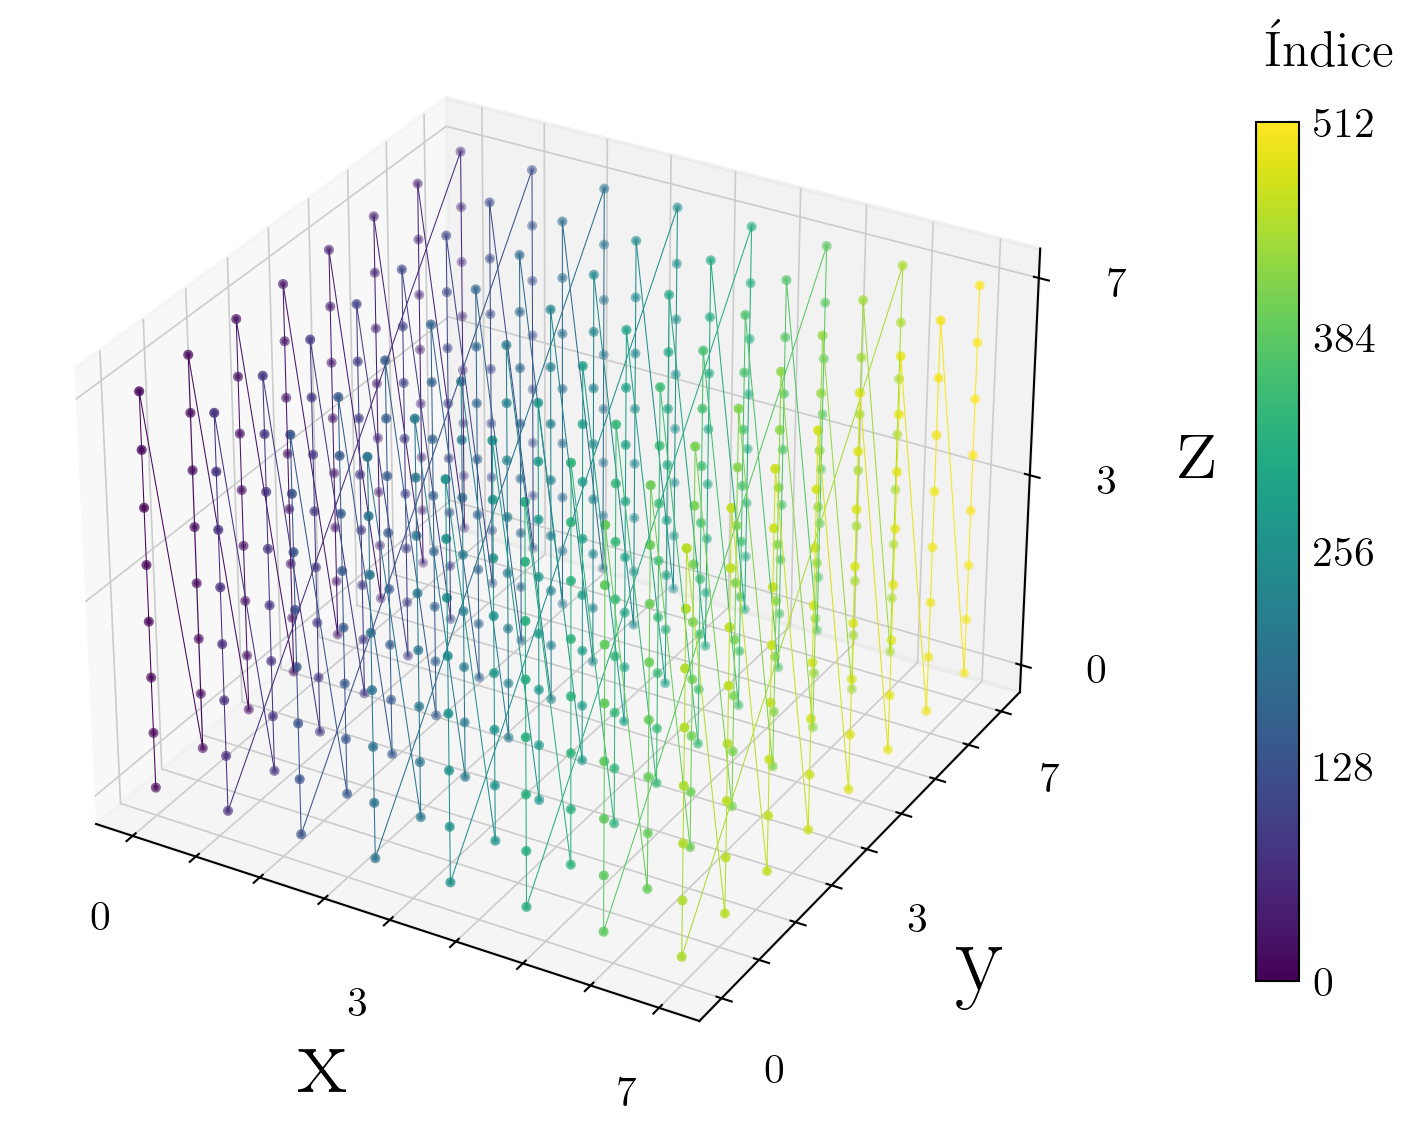

In [6]:
DATA_FOLDER = os.path.join("out", "regular-8")
CLOUD = "regular-8"
points_unencoded = read_points(os.path.join(DATA_FOLDER, f'output_unencoded.csv'))
plot_3d_points_with_hue(points_unencoded, 10000, f'plot_{CLOUD}_unencoded.png', draw_line = True, point_width=2)

/tmp/ipykernel_27426/259886292.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing line segments...
Drawing points...
Saving image...
Plot saved as reorder_plots/plot_regular-8_morton.pdf


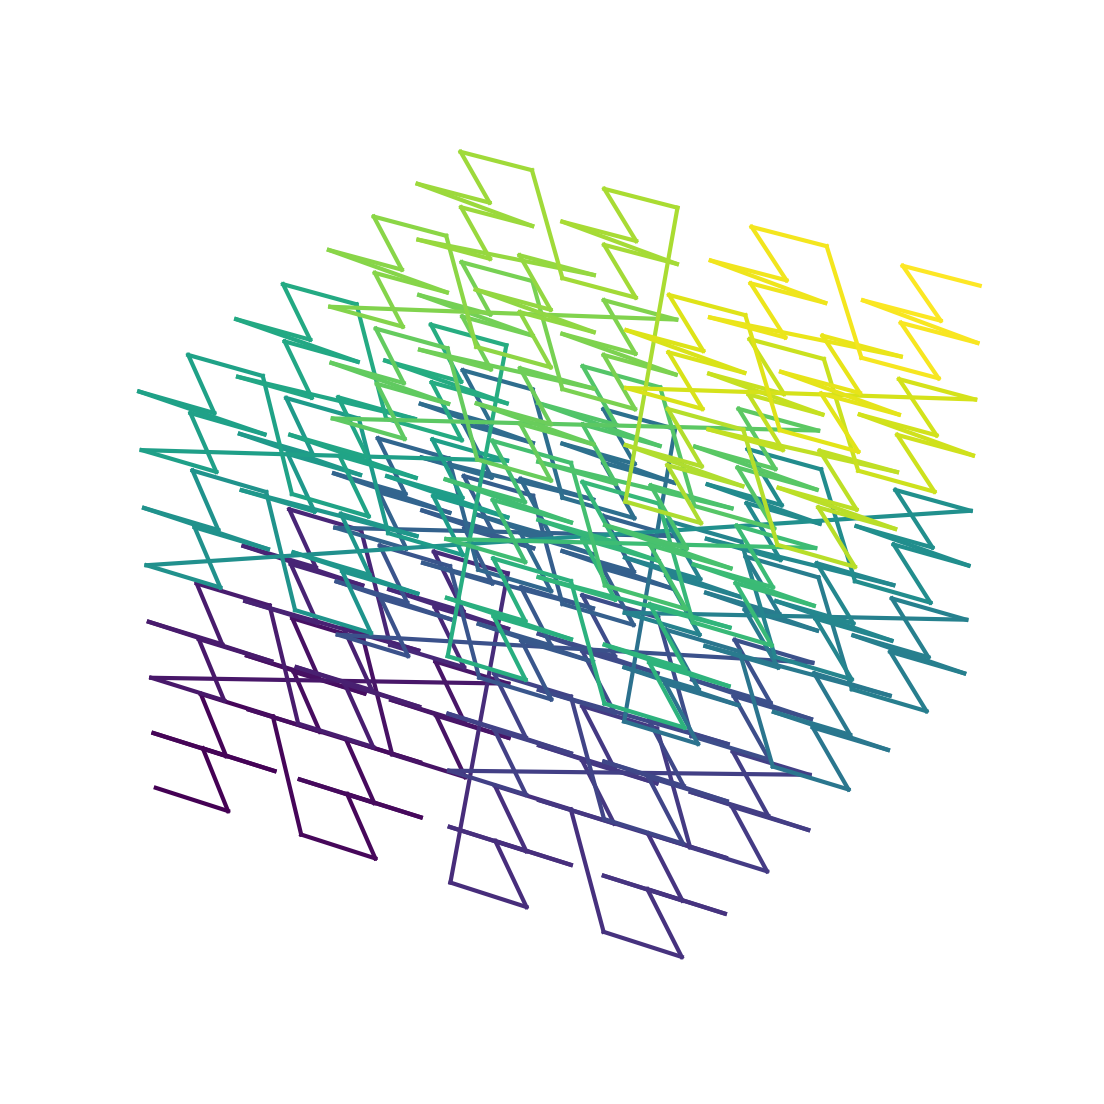

In [7]:
points_mort = read_points(os.path.join(DATA_FOLDER, f'output_morton.csv'))
plot_3d_points_with_hue(points_mort, 10000, f'plot_{CLOUD}_morton.png', draw_line = True, 
                        point_width=0, line_width=1, remove_decorations=True)

Drawing line segments...


/tmp/ipykernel_27426/259886292.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing points...
Saving image...
Plot saved as reorder_plots/plot_regular-8_hilbert.pdf


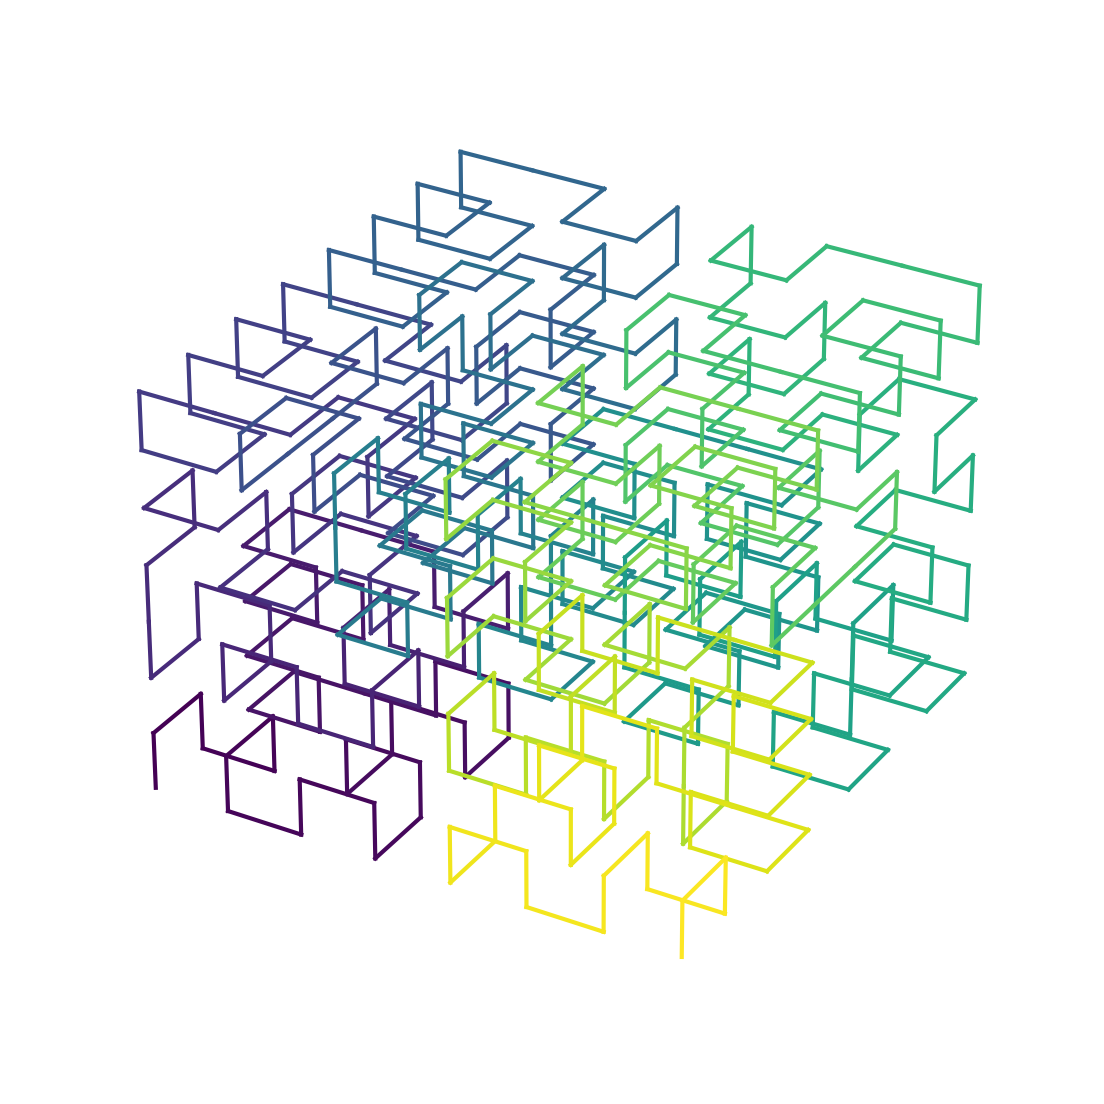

In [8]:
points_hilb = read_points(os.path.join(DATA_FOLDER, f'output_hilbert.csv'))
plot_3d_points_with_hue(points_hilb, 10000, f'plot_{CLOUD}_hilbert.png', draw_line=True, 
                        point_width=0, line_width=1, remove_decorations=True)